In [1]:
import jax
import jax.numpy as jnp
import jax.random as random
from jax.scipy.special import expit, logit
import numpy as np
from tqdm import tqdm
import numpyro
import numpyro.distributions as dist
import src.Aux_functions as aux
from itertools import combinations
import matplotlib.pyplot as plt 
import time 
import blackjax 

print("JAX version: {}".format(jax.__version__))
print("blackjax version: {}".format(blackjax.__version__))



JAX version: 0.4.28
blackjax version: 1.2.0


In [2]:
print(logit(0.9),logit(0.2), expit(logit(0.9)),expit(-2.5))

2.1972244 -1.3862944 0.9 0.075858176


In [35]:
key = random.PRNGKey(0)
key = random.split(key, 1)[0]

# Generate some data
n = 500
triu_dim = n*(n-1)//2

x = random.normal(key, shape=(n,))*3
x2 = random.binomial(key, n=1, p=0.1, shape=(n,))
idx_pairs = list(combinations(range(len(x)), 2))
x_diff = jnp.array([abs(x[i] - x[j]) for i, j in idx_pairs])
x2_or = jnp.array([1 if (x2[i] + x2[j] == 1) else 0 for i, j in idx_pairs])


print(x.shape, x2.shape, x_diff.shape, x2_or.shape)

# Network data

df_edges = jnp.transpose(jnp.stack([jnp.ones(triu_dim), x_diff, x2_or]))
theta = jnp.array([-2.5, -0.5, 1.5])
# gamma = jnp.array([1.1, 0.2, -1, 1])
gamma = jnp.array([logit(.9), logit(.1)])

triu_star_probs = expit(jnp.dot(df_edges, theta))
triu_star = random.binomial(key, n=1, p=triu_star_probs, shape=(triu_dim,))


# triu_obs_probs = expit((triu_star * gamma[0]) + (1 - triu_star) * (gamma[1] + jnp.dot(df_edges, gamma[2:])))
triu_obs_probs = expit(triu_star*gamma[0] + (1 - triu_star)*gamma[1])
triu_obs = random.binomial(key, n=1, p=triu_obs_probs, shape=(triu_dim,))

print(triu_star.shape, triu_obs.shape)

# Outcome data

@jax.jit
def degree_centrality(adj_matrix):
    """
    Compute normalized degree centrality for all nodes in the network using JAX.
    
    Parameters:
    adj_matrix (jnp.ndarray): Square adjacency matrix (n x n)
    
    Returns:
    jnp.ndarray: Vector of normalized degree centralities
    """
    # Compute degrees (sum of rows for undirected graph)
    degrees = jnp.sum(adj_matrix, axis=1)
    
    # Normalize by maximum possible degree (n-1)
    n = adj_matrix.shape[0]
    return degrees / (n - 1)
    
@jax.jit
def compute_exposures(triu_star, Z):
    mat_star = aux.Triu_to_mat(triu_star)
    # eigen_cen = aux.eigen_centrality(mat_star)
    deg_cen = degree_centrality(mat_star)
    return aux.zeigen_value(Z, deg_cen, mat_star)

mat_star = aux.Triu_to_mat(triu_star)
Z = random.binomial(key, n=1, p=0.5, shape=(n,))
# exposures = jnp.dot(mat_star, Z)
exposures = compute_exposures(triu_star, Z)

df_nodes = jnp.transpose(jnp.stack([jnp.ones(n), Z, x, exposures]))
eta = jnp.array([-1, 3, -0.25, 3])

mean_y = jnp.dot(df_nodes, eta)
sig_y = 1

Y = random.normal(key, shape=(n,))*sig_y + mean_y

print(Y.shape)



(500,) (500,) (124750,) (124750,)
(124750,) (124750,)
(500,)


mean exposure:  0.33126655 
 std exposure:  0.3022698 
 median exposure:  0.26553106


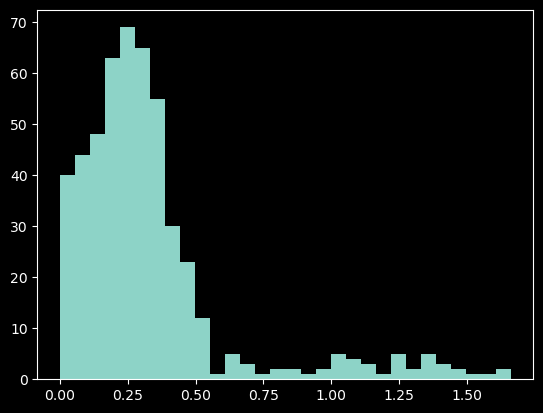

In [4]:
plt.hist(exposures, bins=30)
print("mean exposure: ", jnp.mean(exposures), "\n",
      "std exposure: ", jnp.std(exposures), "\n",
      "median exposure: ", jnp.median(exposures))

(array([17., 14., 16., 37., 22., 37., 83., 60., 46., 55., 46., 11.,  5.,
         4.,  2.,  1.,  3.,  2.,  3.,  3.,  6.,  2.,  4.,  3.,  5.,  5.,
         5.,  0.,  1.,  2.]),
 array([ 1.        ,  3.29999995,  5.5999999 ,  7.9000001 , 10.19999981,
        12.5       , 14.80000019, 17.10000038, 19.39999962, 21.70000076,
        24.        , 26.29999924, 28.60000038, 30.89999962, 33.20000076,
        35.5       , 37.79999924, 40.09999847, 42.40000153, 44.70000076,
        47.        , 49.29999924, 51.59999847, 53.90000153, 56.20000076,
        58.5       , 60.79999924, 63.09999847, 65.40000153, 67.69999695,
        70.        ]),
 <BarContainer object of 30 artists>)

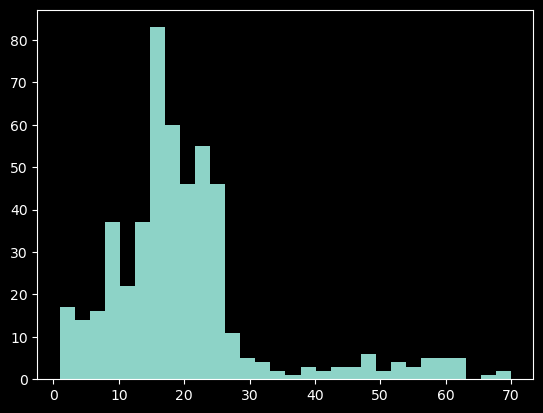

In [5]:
plt.hist(jnp.sum(mat_star, axis=1), bins=30)

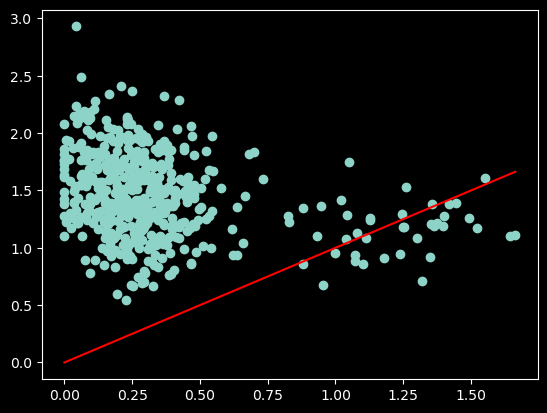

In [36]:
expos_obs = compute_exposures(triu_obs, Z)

plt.scatter(exposures, expos_obs)
# create y~x line
x_line = np.linspace(min(exposures), max(exposures), 100)
y_line = x_line
plt.plot(x_line, y_line, color='red')

(array([ 14.,  45.,  96., 129., 104.,  72.,  31.,   7.,   1.,   1.]),
 array([0.54909819, 0.78717434, 1.02525043, 1.26332664, 1.50140274,
        1.73947895, 1.97755504, 2.21563125, 2.45370746, 2.69178343,
        2.92985964]),
 <BarContainer object of 10 artists>)

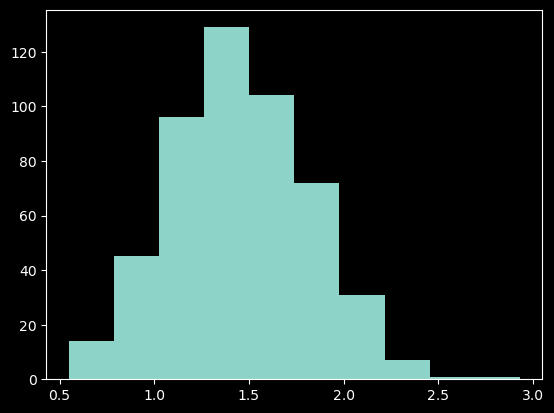

In [37]:
plt.hist(expos_obs)

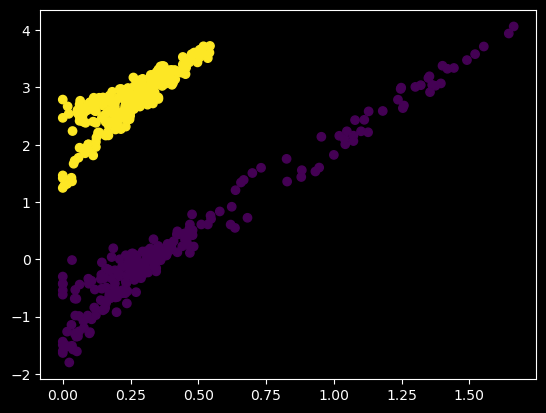

In [8]:
plt.scatter(exposures, Y, c=Z)

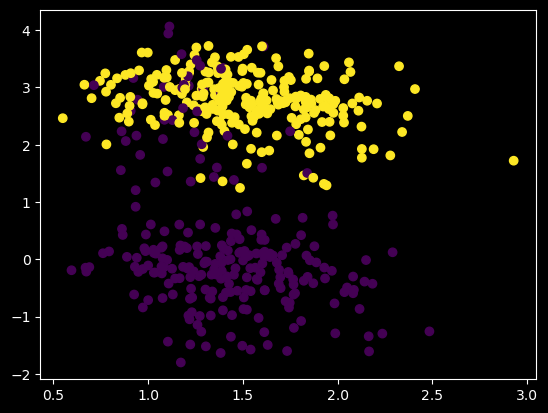

In [38]:
plt.scatter(expos_obs, Y, c=Z)

In [39]:
@jax.jit
def A_star_cond_log_post(triu_star, triu_obs, df_edges, theta, gamma):
    logits_a_star = jnp.dot(df_edges, theta)
    # a_star_log_likelihood = triu_star * (-jnp.log1p(jnp.exp(-logits_a_star))) + (1 - triu_star) * (-jnp.log1p(jnp.exp(logits_a_star)))
    a_star_log_likelihood = triu_star*logits_a_star - jnp.log1p(jnp.exp(logits_a_star))

    # logits_a_obs = (triu_star * gamma[0]) + (1 - triu_star) * (gamma[1] + jnp.dot(df_edges, gamma[2:]))
    logits_a_obs = triu_star*gamma[0] + (1 - triu_star)*gamma[1]
    # a_obs_log_likelihood = triu_obs * (-jnp.log1p(jnp.exp(-logits_a_obs))) + (1 - triu_obs) * (-jnp.log1p(jnp.exp(logits_a_obs)))
    a_obs_log_likelihood = triu_obs*logits_a_obs - jnp.log1p(jnp.exp(logits_a_obs))

    log_prob = a_star_log_likelihood + a_obs_log_likelihood 
    log_prob_sum = jnp.sum(log_prob)

    return log_prob_sum, log_prob


@jax.jit
def A_star_cond_log_post_with_Y(triu_star, triu_obs, df_edges, theta, gamma, Y, X, Z, eta):
    log_prob_sum_n, log_prob_n = A_star_cond_log_post(triu_star, triu_obs, df_edges, theta, gamma)
    # curr_a_star = aux.Triu_to_mat(triu_star)
    # exposures = jnp.dot(curr_a_star, Z)
    exposures = compute_exposures(triu_star, Z)
    df_nodes = jnp.transpose(jnp.stack([jnp.ones(n), Z, X, exposures]))
    mean_y = jnp.dot(df_nodes, eta)
    y_log_likelihood = - 0.5 * jnp.sum((Y - mean_y)**2)

    return log_prob_sum_n + y_log_likelihood, log_prob_n + y_log_likelihood


In [40]:
print(A_star_cond_log_post(triu_star, triu_obs, df_edges, theta, gamma))
print(A_star_cond_log_post_with_Y(triu_star, triu_obs, df_edges, theta, gamma, Y, x, Z, eta))

(Array(-58696.355, dtype=float32), Array([-0.12490855, -0.12892868, -0.10976784, ..., -0.12576193,
       -0.16975422, -0.12192333], dtype=float32))
(Array(-58968.49, dtype=float32), Array([-272.25696, -272.261  , -272.24182, ..., -272.2578 , -272.30182,
       -272.25397], dtype=float32))


(124750,) (124750,)
-58968.49 
 [-4.0041294  -5.6607227  -0.09660435 -5.2226014  -1.4445118  -6.456949
 -7.467518   -1.1351991  -4.471914  ]


(array([1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 3.000e+00,
        0.000e+00, 1.000e+00, 4.000e+00, 3.000e+00, 4.000e+00, 7.000e+00,
        5.000e+00, 4.000e+00, 1.400e+01, 9.000e+00, 1.100e+01, 2.100e+01,
        1.700e+01, 2.700e+01, 3.700e+01, 5.100e+01, 6.900e+01, 6.300e+01,
        8.100e+01, 1.080e+02, 1.360e+02, 1.450e+02, 1.750e+02, 1.890e+02,
        2.370e+02, 2.840e+02, 3.130e+02, 3.780e+02, 4.310e+02, 4.880e+02,
        5.810e+02, 6.200e+02, 7.120e+02, 8.300e+02, 9.240e+02, 1.080e+03,
        1.175e+03, 1.405e+03, 1.563e+03, 1.642e+03, 1.701e+03, 1.774e+03,
        1.921e+03, 2.063e+03, 2.324e+03, 2.577e+03, 2.765e+03, 3.015e+03,
        3.242e+03, 3.512e+03, 3.645e+03, 3.971e+03, 4.159e+03, 4.356e+03,
        4.727e+03, 4.842e+03, 5.192e+03, 5.397e+03, 5.603e+03, 5.784e+03,
        5.887e+03, 5.899e+03, 5.098e+03, 2.656e+03, 1.561e+03, 1.291e+03,
        1.286e+03, 1.260e+03, 1.290e+03, 1.293e+03, 1.328e+03, 1.277e+03,
        1.001e+03, 4.010e+02, 3.070e+0

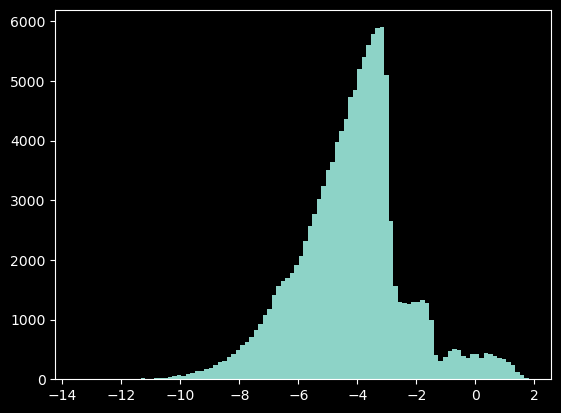

In [41]:
# val_grad_fn = jax.value_and_grad(A_star_cond_log_post, argnums=0, has_aux=True) 
val_grad_fn = jax.value_and_grad(A_star_cond_log_post_with_Y, argnums=0, has_aux=True) 

# (sum_logprob, log_prob), gradient = val_grad_fn(triu_star, triu_obs, df_edges, theta, gamma)
(sum_logprob, log_prob), gradient = val_grad_fn(triu_star, triu_obs, df_edges, theta, gamma, Y, x, Z, eta)
print(log_prob.shape, gradient.shape)
print(sum_logprob, "\n", gradient[1:10])

# create histogram of gradient

plt.hist(gradient, bins=100)

In [8]:
# create a function that `flip` triu_star value (0->1, 1->0), each at a time
#  and for each flip compute difference in log prob (sum)

@jax.jit
def edge_flip_loglik(triu_star, triu_obs, df_edges, theta, gamma, idx):
    new_triu_star = triu_star.at[idx].set(1 - triu_star[idx])
    _ ,log_prob = A_star_cond_log_post(new_triu_star[idx], triu_obs[idx], df_edges[idx,:], theta, gamma)
    return log_prob
    # return log_prob[idx]

# now wrap for all idx

@jax.jit
def flip_triu_star_all(triu_star, triu_obs, df_edges, theta, gamma, idx_set):
    return jnp.array([edge_flip_loglik(triu_star, triu_obs, df_edges, theta, gamma, idx) for idx in tqdm(idx_set)])

(124750,) (124750,)
flip check True
flip check 2 False
manual flip time 0.08007001876831055
(100,)


100%|██████████| 100/100 [00:00<00:00, 1508.11it/s]


func flip time 5.7118821144104
(100,)
True


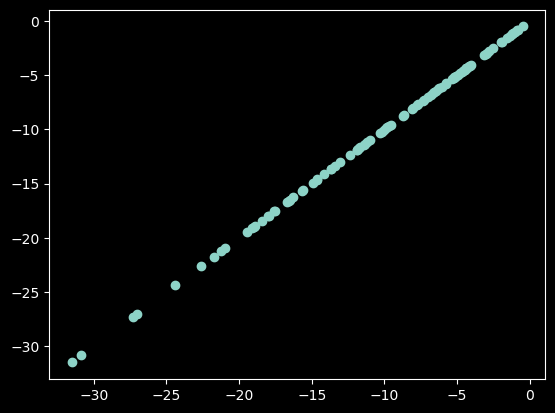

In [8]:
# samples idx_set as 100 values from triu_star

idx_set = random.choice(key, triu_dim, shape=(100,), replace=False)
# print(idx_set)

new_triu_star = triu_star.at[idx_set].set(1 - triu_star[idx_set])
print(triu_star.shape, new_triu_star.shape)

print("flip check", jnp.allclose(new_triu_star[idx_set], 1 - triu_star[idx_set]))
print("flip check 2", jnp.allclose(new_triu_star[idx_set],triu_star[idx_set]))


start = time.time()
_, manual_flip_loglik = A_star_cond_log_post(new_triu_star[idx_set], 
                                             triu_obs[idx_set],
                                               df_edges[idx_set,:],
                                                theta, gamma)
print("manual flip time", time.time() - start)

# manual_flip_loglik_min = manual_flip_loglik[idx_set]
print(manual_flip_loglik.shape)
# print(manual_flip_loglik_min.shape)

start = time.time()
func_flip_loglik = flip_triu_star_all(triu_star, triu_obs, df_edges, theta, gamma, idx_set)
print("func flip time", time.time() - start)

print(func_flip_loglik.shape)

print(jnp.allclose(manual_flip_loglik, func_flip_loglik))

plt.scatter(manual_flip_loglik, func_flip_loglik)

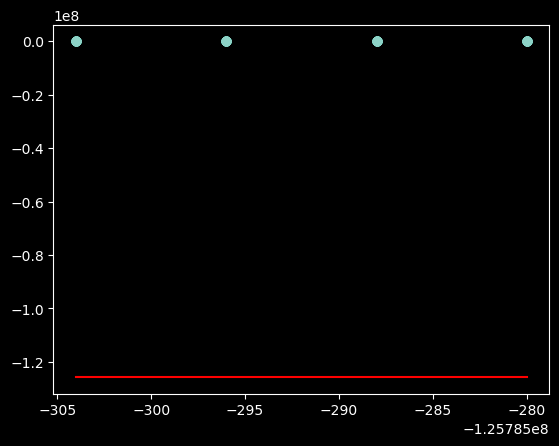

In [58]:
#  manual diff

# _, f_a = A_star_cond_log_post(triu_star, triu_obs, df_edges, theta, gamma)
# _, f_a_tag = A_star_cond_log_post(1-triu_star, triu_obs, df_edges, theta, gamma)
_, f_a = A_star_cond_log_post_with_Y(triu_star, triu_obs, df_edges, theta, gamma, Y, x, Z, eta)
_, f_a_tag = A_star_cond_log_post_with_Y(1-triu_star, triu_obs, df_edges, theta, gamma, Y, x, Z, eta)

grad_manual = f_a_tag - f_a

# score_grad = jnp.sum(-(2*triu_star-1)*gradient)
score_grad = -(2*triu_star-1)*gradient

# plt.hist(score_grad, bins=100)
plt.scatter(grad_manual, score_grad)
#  add y~x line
plt.plot([min(grad_manual), max(grad_manual)], [min(grad_manual), max(grad_manual)], color='red')
# plt.hist(grad_manual - score_grad, bins=100)

min:  0.0010285038 max:  0.9964398 
 mean:  0.17779611 median:  0.118299514 
 q025:  0.017219523 q975:  0.937523
min:  0.00013931675 max:  0.97427845 
 mean:  0.05079209 median:  0.017834362 
 q025:  0.002365631 q975:  0.6700569


(array([1.217e+03, 3.230e+03, 4.247e+03, 5.097e+03, 5.721e+03, 6.156e+03,
        6.306e+03, 6.363e+03, 6.466e+03, 6.473e+03, 6.299e+03, 6.156e+03,
        6.036e+03, 5.945e+03, 5.669e+03, 5.317e+03, 3.877e+03, 2.099e+03,
        1.348e+03, 1.233e+03, 1.162e+03, 1.126e+03, 1.061e+03, 1.156e+03,
        1.091e+03, 1.121e+03, 1.195e+03, 1.108e+03, 1.097e+03, 9.170e+02,
        5.790e+02, 5.320e+02, 5.090e+02, 4.830e+02, 4.530e+02, 4.900e+02,
        5.280e+02, 4.990e+02, 4.770e+02, 4.830e+02, 5.010e+02, 5.470e+02,
        5.200e+02, 5.450e+02, 5.180e+02, 5.320e+02, 5.320e+02, 5.070e+02,
        5.150e+02, 5.130e+02, 5.080e+02, 5.140e+02, 4.630e+02, 4.160e+02,
        3.170e+02, 2.250e+02, 1.620e+02, 1.320e+02, 1.960e+02, 1.570e+02,
        1.610e+02, 1.470e+02, 1.420e+02, 1.100e+02, 9.100e+01, 7.000e+01,
        5.500e+01, 4.200e+01, 2.400e+01, 1.600e+01, 6.000e+00, 4.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

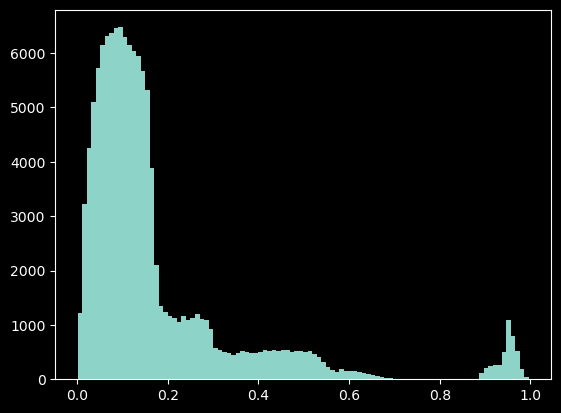

In [59]:
# grad_on_idx = (f_a_tag - f_a)/2
grad_on_idx = score_grad / 2

flip_probs = jnp.exp(grad_on_idx) / (jnp.exp(grad_on_idx) + 1)

# print summary of probs
print("min: ", jnp.min(flip_probs), "max: ", jnp.max(flip_probs), "\n",
      "mean: ", jnp.mean(flip_probs),
      "median: ", jnp.median(flip_probs), "\n",
      "q025: ", jnp.quantile(flip_probs, 0.025),
        "q975: ", jnp.quantile(flip_probs, 0.975))

flip_probs_rate = jnp.exp(grad_on_idx - 2) / (jnp.exp(grad_on_idx - 2) + 1)

# print summary of probs
print("min: ", jnp.min(flip_probs_rate), "max: ", jnp.max(flip_probs_rate), "\n",
      "mean: ", jnp.mean(flip_probs_rate),
      "median: ", jnp.median(flip_probs_rate), "\n",
      "q025: ", jnp.quantile(flip_probs_rate, 0.025),
        "q975: ", jnp.quantile(flip_probs_rate, 0.975))

plt.hist(flip_probs, bins=100)

0.2677551 267.75507
0.09841587
9.357623e-14


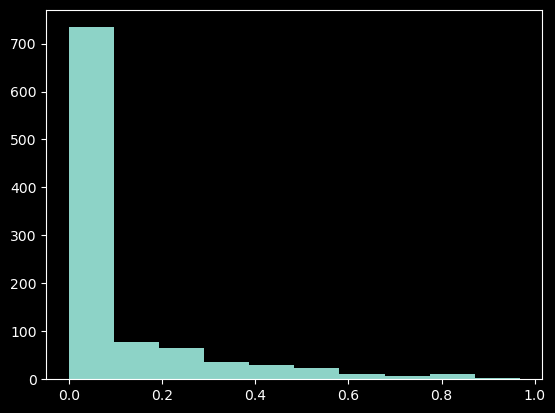

In [55]:
idxs = random.choice(key, triu_dim, shape=(1000,), replace=False)
prop_triu = triu_star.at[idxs].set(1 - triu_star[idxs])

_, tst_grad = val_grad_fn(triu_star, triu_obs, df_edges,
                                            theta, gamma, Y, x, Z, eta)
tst_grad = tst_grad[idxs]

temp_ratio = jnp.exp((-(2*triu_star[idxs]-1)*tst_grad)/2. - 0)
print(temp_ratio.mean(), temp_ratio.sum())
temp_ratio = jnp.clip(temp_ratio, -30, 30)
temp_prob = temp_ratio / (temp_ratio + 1)
print(temp_prob.mean())

plt.hist(temp_prob)

print(jnp.exp(-30) / (jnp.exp(-30) + 1))

In [42]:
# g_grad = jnp.exp(score_grad) / (jnp.exp(score_grad) + 1)
# g_grad = score_grad / 2

# print(g_grad.min(), g_grad.max())
# tst_samp = random.categorical(key, logits=g_grad, shape=(1,))
# print(tst_samp, g_grad[tst_samp])

def weighted_sample_and_logprobs(key, scores, M):
    # Get samples using Gumbel-max trick
    gumbel_noise = random.gumbel(key, shape=scores.shape)
    perturbed = scores + gumbel_noise
    selected_indices = jnp.argsort(-perturbed)[:M]

     # Compute log probabilities
    # log_probs = jax.nn.log_softmax(scores)
    log_probs = jax.nn.log_softmax(scores)
    # print("min log prob: ", jnp.min(log_probs), "max log prob: ", jnp.max(log_probs), "\n",
    #       "std log prob: ", jnp.std(log_probs), "mean log prob: ", jnp.mean(log_probs), "\n",
    #       "median log prob: ", jnp.median(log_probs))
    selected_log_probs = log_probs[selected_indices]
    # print("select", selected_log_probs)

    return selected_indices, selected_log_probs.sum()

@jax.jit
def propsal_logprobs(idx, scores):
    log_probs = jax.nn.log_softmax(scores)
    return log_probs[idx].sum()



# w_samp, w_logprob = weighted_sample_and_logprobs(key, g_grad, 3)
# print(w_samp, g_grad[w_samp])
# print(w_logprob)


In [55]:
TRIU_LEN = triu_star.shape[0]
BATCH_PROP = .001
# BATCH_LEN = int(TRIU_LEN * BATCH_PROP)
# BATCH_LEN = 500
# BATCH_LEN = 5
# BATCH_LEN = 2*jnp.ceil(jnp.log(n)).astype(int)
# BATCH_LEN = jnp.ceil(jnp.log(TRIU_LEN)).astype(int)
BATCH_LEN = jnp.ceil(jnp.log(TRIU_LEN)/2).astype(int)
print(BATCH_LEN)

@jax.jit
def triu_star_update(triu_star, triu_obs, df_edges, theta, gamma,
                      Y, X, Z, eta, key, alpha = jnp.log(2), eps = 1e-10):

    key1, key2 = random.split(key, 2)

    (f_cur,_), cur_grad = val_grad_fn(triu_star, triu_obs, df_edges, theta, gamma, Y, X, Z, eta)
    cur_scores = (-(2*triu_star-1)*cur_grad)/2

    # idx, forward_logprob = weighted_sample_and_logprobs(key1, cur_scores*jnp.exp(-alpha), BATCH_LEN)
    idx, forward_logprob = weighted_sample_and_logprobs(key1, cur_scores*jnp.exp(-alpha), BATCH_LEN)

    new_triu_star = triu_star.at[idx].set(1 - triu_star[idx])

    # backward proposal
    (f_proposed,_), backward_edge_loglik = val_grad_fn(new_triu_star, triu_obs, df_edges,
                                        theta, gamma, Y, X, Z, eta)
    backward_scores = (-(2*new_triu_star-1)*backward_edge_loglik)/2
    backward_logprob = propsal_logprobs(idx, backward_scores*jnp.exp(-alpha))

    # get acceptance ratio (exp of log probs)
    acceptance_ratio = jnp.clip(jnp.exp(f_proposed - f_cur + backward_logprob - forward_logprob),
                                a_max=1)
    # accept or reject
    accept = random.uniform(key2) <= acceptance_ratio

    # update triu_star
    new_triu_star = jax.lax.select(accept, new_triu_star, triu_star)
    # new_scores = jax.lax.select(accept, backward_scores, cur_scores)
    new_logpost = jax.lax.select(accept, f_proposed, f_cur)
    # return new_triu_star, acceptance_ratio
    # return new_triu_star, acceptance_ratio, new_scores, new_logpost
    return new_triu_star, acceptance_ratio, new_logpost
    
     

6


In [44]:
@jax.jit
def adaptive_step_size(alpha, acceptance_rate, target_rate=0.574, gamma=0.05):
    """
    Updates step size alpha based on the observed acceptance rate.
    """
    adjustment = gamma * (target_rate - acceptance_rate)
    return alpha + adjustment

In [56]:
# make noisy triu_star
key,_  = random.split(key)
triu_star_noisy = (triu_star * random.binomial(key, n=1, p=0.9, shape=(triu_dim,)) +
                   (1-triu_star) * random.binomial(key, n=1, p=0.1, shape=(triu_dim,)))

eta_n = eta 
eta_n = eta_n.at[3].set(eta_n[3] - 2.0)
theta_n = theta
theta_n = theta_n.at[1].set(theta_n[1] - 1.5)
# theta_n[1] = theta_n[1] - 1.5
# test A_star update

# alpha = jnp.log(2.0)
alpha = 1.
n_iter = 5000
new_triu_star = triu_star_noisy
# new_triu_star = triu_obs
exposures_lst = [compute_exposures(new_triu_star, Z)]
log_post = []
acceptance_rates = []
# acceptance_rates = jnp.zeros
ADAPT_WINDOW = 100


start = time.time()
for i in tqdm(range(int(n_iter))):
    key, _ = random.split(key)
  
    new_triu_star, acc, logpost = triu_star_update(new_triu_star, triu_obs, df_edges,
                                      theta, gamma, Y, x, Z, eta, key, alpha=alpha)
    # new_triu_star, acc, cur_scores, cur_logpost = triu_star_update(new_triu_star,
    #                                                                cur_scores, cur_logpost,
    #                                                                 triu_obs, df_edges,
    #                                   theta_n, gamma, Y, x, Z, eta_n, key, alpha=alpha)
    exposures_lst.append(compute_exposures(new_triu_star, Z))
    acceptance_rates.append(acc)
    log_post.append(logpost)
    
    if i % ADAPT_WINDOW == 0:
        # mean_acceptance_rate = jnp.mean(jnp.array(acceptance_rates[-ADAPT_WINDOW:]))
        mean_acceptance_rate = np.mean(acceptance_rates[-ADAPT_WINDOW:])
        alpha = adaptive_step_size(alpha, mean_acceptance_rate)
        print(f"Iteration {i}, New Alpha: {alpha}, Acceptance Rate: {mean_acceptance_rate}")

        # eta_n[-1] = eta_n[-1] + 0.04
        # eta_n = eta_n.at[3].set(eta_n[3] + 0.02)
        # theta_n[1] = theta_n[1] + 0.03
        # theta_n = theta_n.at[1].set(theta_n[1] + 0.015)

print("for loop total time: ", time.time() - start)

    


  0%|          | 1/5000 [00:02<3:46:12,  2.72s/it]

Iteration 0, New Alpha: 0.9786999821662903, Acceptance Rate: 1.0


  2%|▏         | 104/5000 [00:11<05:48, 14.06it/s]

Iteration 100, New Alpha: 0.9573999643325806, Acceptance Rate: 1.0


  4%|▍         | 202/5000 [00:18<05:23, 14.82it/s]

Iteration 200, New Alpha: 0.9360999464988708, Acceptance Rate: 1.0


  6%|▌         | 302/5000 [00:25<05:05, 15.38it/s]

Iteration 300, New Alpha: 0.9147999286651611, Acceptance Rate: 1.0


  8%|▊         | 402/5000 [00:32<06:52, 11.14it/s]

Iteration 400, New Alpha: 0.8934999108314514, Acceptance Rate: 1.0


 10%|█         | 504/5000 [00:39<04:47, 15.63it/s]

Iteration 500, New Alpha: 0.8721998929977417, Acceptance Rate: 1.0


 12%|█▏        | 602/5000 [00:46<04:59, 14.68it/s]

Iteration 600, New Alpha: 0.850899875164032, Acceptance Rate: 1.0


 14%|█▍        | 703/5000 [00:53<04:21, 16.45it/s]

Iteration 700, New Alpha: 0.8300979137420654, Acceptance Rate: 0.9900389313697815


 16%|█▌        | 803/5000 [00:59<04:20, 16.11it/s]

Iteration 800, New Alpha: 0.8099686503410339, Acceptance Rate: 0.9765850901603699


 18%|█▊        | 903/5000 [01:06<04:17, 15.91it/s]

Iteration 900, New Alpha: 0.7908055186271667, Acceptance Rate: 0.957263171672821


 20%|██        | 1003/5000 [01:12<03:55, 17.00it/s]

Iteration 1000, New Alpha: 0.7708133459091187, Acceptance Rate: 0.9738436937332153


 22%|██▏       | 1103/5000 [01:19<04:25, 14.67it/s]

Iteration 1100, New Alpha: 0.7519065737724304, Acceptance Rate: 0.9521359205245972


 24%|██▍       | 1203/5000 [01:25<04:03, 15.62it/s]

Iteration 1200, New Alpha: 0.7340772151947021, Acceptance Rate: 0.9305866360664368


 26%|██▌       | 1303/5000 [01:32<04:21, 14.14it/s]

Iteration 1300, New Alpha: 0.7156187891960144, Acceptance Rate: 0.9431688189506531


 28%|██▊       | 1403/5000 [01:39<03:52, 15.48it/s]

Iteration 1400, New Alpha: 0.7007876038551331, Acceptance Rate: 0.870623767375946


 30%|███       | 1503/5000 [01:46<03:41, 15.78it/s]

Iteration 1500, New Alpha: 0.6858422160148621, Acceptance Rate: 0.8729081153869629


 32%|███▏      | 1603/5000 [01:53<03:54, 14.47it/s]

Iteration 1600, New Alpha: 0.66669762134552, Acceptance Rate: 0.9568922519683838


 34%|███▍      | 1703/5000 [01:59<03:41, 14.89it/s]

Iteration 1700, New Alpha: 0.6513057351112366, Acceptance Rate: 0.8818375468254089


 36%|███▌      | 1803/5000 [02:06<03:34, 14.90it/s]

Iteration 1800, New Alpha: 0.634573757648468, Acceptance Rate: 0.9086397290229797


 38%|███▊      | 1903/5000 [02:13<03:32, 14.56it/s]

Iteration 1900, New Alpha: 0.617933988571167, Acceptance Rate: 0.9067955613136292


 40%|████      | 2003/5000 [02:20<03:19, 15.02it/s]

Iteration 2000, New Alpha: 0.6053075194358826, Acceptance Rate: 0.8265291452407837


 42%|████▏     | 2103/5000 [02:27<03:11, 15.12it/s]

Iteration 2100, New Alpha: 0.5899417400360107, Acceptance Rate: 0.8813157081604004


 44%|████▍     | 2203/5000 [02:34<03:01, 15.44it/s]

Iteration 2200, New Alpha: 0.5751917362213135, Acceptance Rate: 0.8689997792243958


 46%|████▌     | 2303/5000 [02:41<03:07, 14.41it/s]

Iteration 2300, New Alpha: 0.5647213459014893, Acceptance Rate: 0.7834077477455139


 48%|████▊     | 2403/5000 [02:47<02:52, 15.03it/s]

Iteration 2400, New Alpha: 0.5517009496688843, Acceptance Rate: 0.8344084024429321


 50%|█████     | 2503/5000 [02:54<02:49, 14.73it/s]

Iteration 2500, New Alpha: 0.5390060544013977, Acceptance Rate: 0.8278980851173401


 52%|█████▏    | 2603/5000 [03:01<02:36, 15.35it/s]

Iteration 2600, New Alpha: 0.5259561538696289, Acceptance Rate: 0.8349975347518921


 54%|█████▍    | 2703/5000 [03:08<02:53, 13.27it/s]

Iteration 2700, New Alpha: 0.5112866163253784, Acceptance Rate: 0.8673908710479736


 56%|█████▌    | 2803/5000 [03:15<02:27, 14.88it/s]

Iteration 2800, New Alpha: 0.5019372701644897, Acceptance Rate: 0.760987401008606


 58%|█████▊    | 2903/5000 [03:22<02:21, 14.83it/s]

Iteration 2900, New Alpha: 0.4914906919002533, Acceptance Rate: 0.7829318046569824


 60%|██████    | 3003/5000 [03:35<02:40, 12.46it/s]

Iteration 3000, New Alpha: 0.4803842604160309, Acceptance Rate: 0.796128511428833


 62%|██████▏   | 3102/5000 [03:43<02:27, 12.87it/s]

Iteration 3100, New Alpha: 0.4669943153858185, Acceptance Rate: 0.8417989611625671


 64%|██████▍   | 3202/5000 [03:51<02:35, 11.55it/s]

Iteration 3200, New Alpha: 0.4545741081237793, Acceptance Rate: 0.8224042654037476


 66%|██████▌   | 3304/5000 [03:58<01:48, 15.69it/s]

Iteration 3300, New Alpha: 0.4411816895008087, Acceptance Rate: 0.8418484330177307


 68%|██████▊   | 3402/5000 [04:05<02:33, 10.43it/s]

Iteration 3400, New Alpha: 0.43548184633255005, Acceptance Rate: 0.6879971027374268


 70%|███████   | 3504/5000 [04:13<01:36, 15.45it/s]

Iteration 3500, New Alpha: 0.4268701374530792, Acceptance Rate: 0.7462338805198669


 72%|███████▏  | 3602/5000 [04:19<01:35, 14.66it/s]

Iteration 3600, New Alpha: 0.4161730706691742, Acceptance Rate: 0.7879411578178406


 74%|███████▍  | 3702/5000 [04:26<01:31, 14.21it/s]

Iteration 3700, New Alpha: 0.40642833709716797, Acceptance Rate: 0.7688949108123779


 76%|███████▌  | 3802/5000 [04:33<01:16, 15.73it/s]

Iteration 3800, New Alpha: 0.39553728699684143, Acceptance Rate: 0.7918210625648499


 78%|███████▊  | 3902/5000 [04:40<01:14, 14.82it/s]

Iteration 3900, New Alpha: 0.384418249130249, Acceptance Rate: 0.7963806390762329


 80%|████████  | 4002/5000 [04:47<01:09, 14.35it/s]

Iteration 4000, New Alpha: 0.3760111927986145, Acceptance Rate: 0.7421409487724304


 82%|████████▏ | 4102/5000 [04:53<00:59, 15.12it/s]

Iteration 4100, New Alpha: 0.3673960864543915, Acceptance Rate: 0.7463021278381348


 84%|████████▍ | 4202/5000 [05:01<00:59, 13.48it/s]

Iteration 4200, New Alpha: 0.3573281168937683, Acceptance Rate: 0.7753590941429138


 86%|████████▌ | 4302/5000 [05:08<00:48, 14.44it/s]

Iteration 4300, New Alpha: 0.34922319650650024, Acceptance Rate: 0.7360984683036804


 88%|████████▊ | 4404/5000 [05:15<00:38, 15.34it/s]

Iteration 4400, New Alpha: 0.3415449857711792, Acceptance Rate: 0.7275640964508057


 90%|█████████ | 4504/5000 [05:21<00:33, 15.02it/s]

Iteration 4500, New Alpha: 0.3338651955127716, Acceptance Rate: 0.7275958061218262


 92%|█████████▏| 4604/5000 [05:28<00:23, 16.84it/s]

Iteration 4600, New Alpha: 0.32367032766342163, Acceptance Rate: 0.7778972387313843


 94%|█████████▍| 4702/5000 [05:35<00:31,  9.36it/s]

Iteration 4700, New Alpha: 0.3204789161682129, Acceptance Rate: 0.6378281712532043


 96%|█████████▌| 4804/5000 [05:44<00:12, 15.32it/s]

Iteration 4800, New Alpha: 0.31140950322151184, Acceptance Rate: 0.7553880214691162


 98%|█████████▊| 4903/5000 [05:52<00:07, 13.29it/s]

Iteration 4900, New Alpha: 0.306202232837677, Acceptance Rate: 0.6781452298164368


100%|██████████| 5000/5000 [05:59<00:00, 13.92it/s]

for loop total time:  359.10361433029175


In [81]:
start = time.time()

def scan_body(carry, i):
    # Unpack carry
    key, new_triu_star, alpha, window_acceptances = carry
    
    # # Original loop body
    # key, subkey = random.split(key)
    # new_triu_star, acc, logpost = triu_star_update(
    #     new_triu_star, triu_obs, df_edges,
    #     theta, gamma, Y, x, Z, eta, subkey, alpha=alpha
    # )
    
    # Run triu_star_update 10 times
    def inner_loop(j, loop_carry):
        inner_key, inner_triu, inner_acc, inner_logpost = loop_carry
        inner_key, subkey = random.split(inner_key)
        
        new_inner_triu, acc, logpost = triu_star_update(
            inner_triu, triu_obs, df_edges,
            theta, gamma, Y, x, Z, eta, subkey, alpha=alpha
        )
        return (inner_key, new_inner_triu, acc, logpost)
    
    # Use fori_loop for the inner 10 iterations
    key, subkey = random.split(key)
    key, new_triu_star, acc, logpost = jax.lax.fori_loop(
        0, 5,  # run 10 times
        inner_loop,
        (subkey, new_triu_star, 0.0, 0)  # initial values
    )

    exposures_s = compute_exposures(new_triu_star, Z)
    
    # Handle adaptive step size
    window_acceptances = window_acceptances.at[i % ADAPT_WINDOW].set(acc)
    new_alpha = jax.lax.cond(
        i % ADAPT_WINDOW == ADAPT_WINDOW - 1,
        lambda t: adaptive_step_size(t[0], jnp.mean(t[1])),
        lambda t: t[0],
        (alpha, window_acceptances)
    )
    
    # Return carry and outputs
    new_carry = (key, new_triu_star, new_alpha, window_acceptances)
    outputs = (exposures_s, acc, logpost, new_alpha)
    
    return new_carry, outputs

# Initialize carry values
ADAPT_WINDOW = 25
window_acceptances = jnp.zeros(ADAPT_WINDOW)
init_carry = (key, triu_star_noisy, 1.0, window_acceptances)

# Run scan
final_carry, (exposures_sc, acceptance_rates_sc, log_post_sc, alphas_sc) = jax.lax.scan(
    scan_body,
    init_carry,
    # jnp.arange(n_iter)
    jnp.arange(2000)
)


print("scan total time: ", time.time() - start)
# 

scan total time:  652.0404789447784


In [54]:
print(99 % ADAPT_WINDOW, ADAPT_WINDOW - 1)  

99 99


In [82]:
print("logpost shape", log_post_sc.shape, "\n",
      "exposures shape", exposures_sc.shape, "\n",
      "acceptance rates shape", acceptance_rates_sc.shape, "\n",
      "alpha shape", alphas_sc.shape, "\n",
      "new_triu_star shape", final_carry[1].shape)

logpost shape (2000,) 
 exposures shape (2000, 500) 
 acceptance rates shape (2000,) 
 alpha shape (2000,) 
 new_triu_star shape (124750,)


In [83]:
print(jnp.arange(1000).shape, acceptance_rates_sc.shape)

(1000,) (2000,)


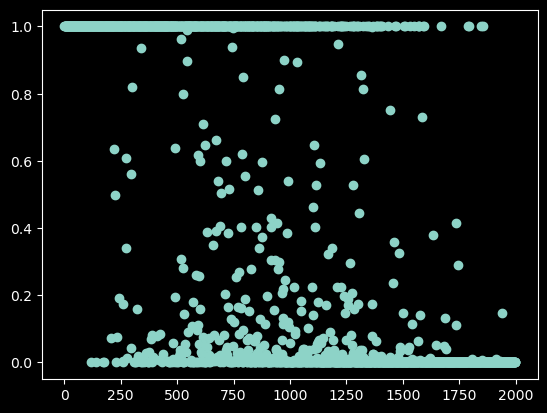

In [84]:
plt.scatter(jnp.arange(2000),acceptance_rates_sc)

In [51]:
jnp.ceil(jnp.log(triu_dim))

Array(12., dtype=float32, weak_type=True)

In [71]:
print(alphas_sc[-1],alpha)
print(exposures.mean())
print(type(jnp.array(exposures_sc)))

1.3524945 0.30620223
0.33126655
<class 'jaxlib.xla_extension.ArrayImpl'>


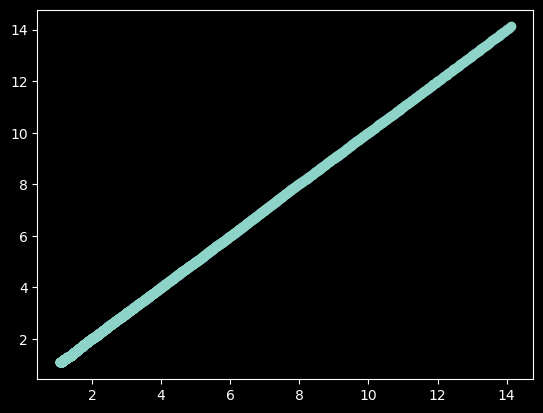

In [47]:
plt.scatter(exposures_sc.mean(axis=1), jnp.array(exposures_lst)[1:].mean(axis=1))
# print(jnp.array(exposures_lst)[1:].shape)

(2000, 500)
0.33126655
0.42035675


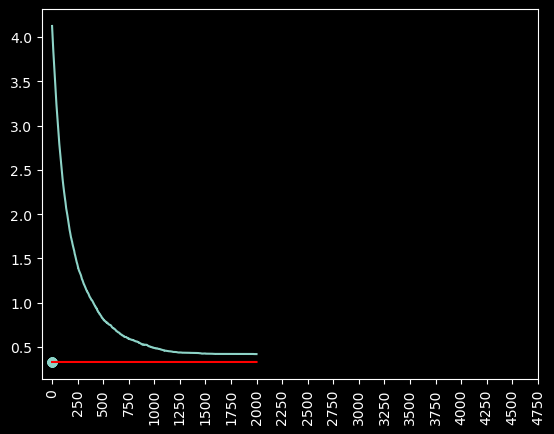

In [85]:
from sympy import rotations


# expos_arr = jnp.array(exposures_lst)[1:]
expos_arr = exposures_sc
print(expos_arr.shape)
print(exposures.mean())
plt.scatter(expos_arr.mean(axis=1), jnp.ones(expos_arr.shape[0])*exposures.mean())
print(expos_arr.mean(axis=1)[-1])

# plt.plot(expos_arr)

# create line plot of expos_arr.mean(axis=1) (y axis) vs the index (x axis)
plt.plot(expos_arr.mean(axis=1))
plt.plot(jnp.ones(expos_arr.shape[0])*exposures.mean(), color='red')
# add x-ticks vertical with 500 step siz
plt.xticks(range(0, n_iter, 250), rotation=90) 
plt.show()

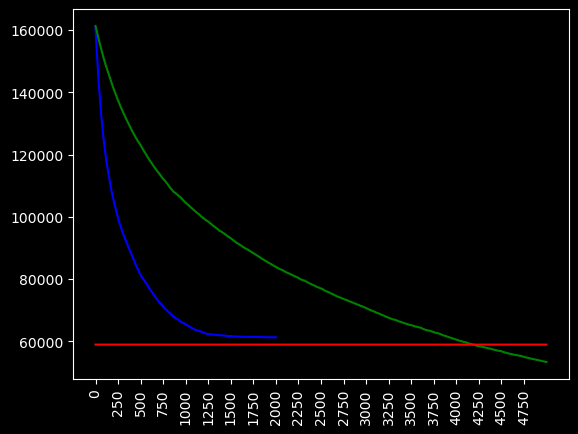

In [86]:
(true_logpost,_), true_grad = val_grad_fn(triu_star, triu_obs, df_edges,
                                            theta, gamma, Y, x, Z, eta)

plt.plot(-jnp.array(log_post_sc), color="blue")
plt.plot(-jnp.array(log_post), color="green")
plt.plot(-jnp.ones(len(log_post))*true_logpost, color="red")
plt.xticks(range(0, n_iter, 250), rotation=90)
plt.show()

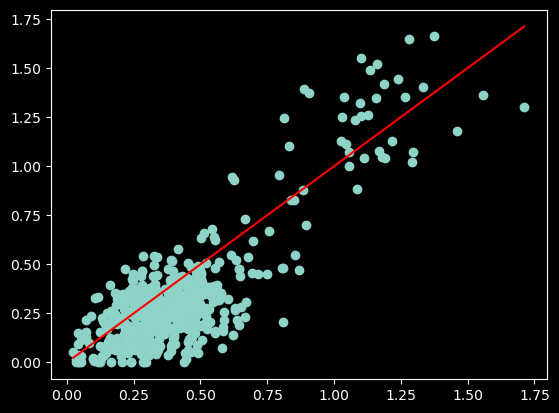

In [87]:
plt.scatter(expos_arr[-1,:], exposures)
# plt.scatter(compute_exposures(triu_obs, Z), exposures)
plt.plot([min(expos_arr[-1,:]), max(expos_arr[-1,:])], [min(expos_arr[-1,:]), max(expos_arr[-1,:])], color='red')

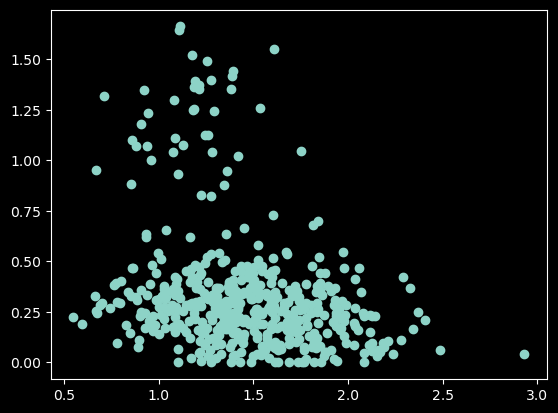

In [60]:
plt.scatter(compute_exposures(triu_obs, Z), exposures)


In [88]:
print(np.corrcoef(expos_arr[-1,:], exposures))
# print(np.corrcoef(compute_exposures(triu_star_noisy, Z), exposures))
print(np.corrcoef(compute_exposures(triu_obs, Z), exposures))

[[1.        0.8365719]
 [0.8365719 1.       ]]
[[ 1.         -0.28469737]
 [-0.28469737  1.        ]]


In [90]:
# print 2x2 table of triu_star and new_triu_star
#  for all values
def binary_contingency_table(A1, A2):
    # Table structure:
    #     A2=0  A2=1
    # A1=0  n00   n01
    # A1=1  n10   n11
    
    n00 = jnp.sum((A1 == 0) & (A2 == 0))
    n01 = jnp.sum((A1 == 0) & (A2 == 1))
    n10 = jnp.sum((A1 == 1) & (A2 == 0))
    n11 = jnp.sum((A1 == 1) & (A2 == 1))
    
    print("A1 \ A2 |  0  |  1  |")
    print("---------|-----|-----|")
    print(f"   0    | {n00:3d} | {n01:3d} |")
    print(f"   1    | {n10:3d} | {n11:3d} |")
    
    return jnp.array([[n00, n01], [n10, n11]])

print(binary_contingency_table(triu_star, new_triu_star))
print(binary_contingency_table(triu_star, final_carry[1]))
print(binary_contingency_table(triu_star, triu_obs))

print(jnp.mean(triu_star == new_triu_star))
print(jnp.mean(triu_star == final_carry[1]))
# print(jnp.mean(triu_star == triu_star_noisy))
print(jnp.mean(triu_star == triu_obs))


# print(jnp.sum(triu_star), jnp.sum(new_triu_star))

A1 \ A2 |  0  |  1  |
---------|-----|-----|
   0    | 116401 | 3303 |
   1    | 3956 | 1090 |
[[116401   3303]
 [  3956   1090]]
A1 \ A2 |  0  |  1  |
---------|-----|-----|
   0    | 115083 | 4621 |
   1    | 3740 | 1306 |
[[115083   4621]
 [  3740   1306]]
A1 \ A2 |  0  |  1  |
---------|-----|-----|
   0    | 111388 | 8316 |
   1    | 4240 | 806 |
[[111388   8316]
 [  4240    806]]
0.94181156
0.9329779
0.89935064


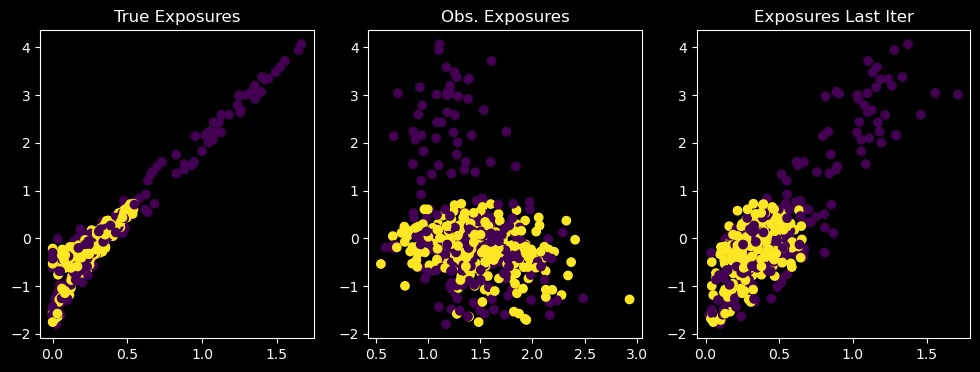

In [177]:
# plot with 3 panels of expos~Y scatter for exposures, expos_obs, expos_arr[-1,:]
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.scatter(exposures, Y-3*Z, c=Z)
plt.title("True Exposures")
plt.subplot(1, 3, 2)
plt.scatter(expos_obs, Y-3*Z, c=Z)
plt.title("Obs. Exposures")
plt.subplot(1, 3, 3)
plt.scatter(expos_arr[-1,:], Y-3*Z, c=Z)
plt.title("Exposures Last Iter")
plt.show()


In [218]:
# Testing blackjax for continuous site (outcome model only)
import blackjax
import blackjax.mcmc.hmc as hmc
from colorama import init
import jax.scipy.stats as stats
import numpyro
import numpyro.distributions as dist
from numpyro.infer.util import initialize_model



def cont_models(X, Z, triu_star, triu_obs, df_edges, Y=None):
    # Outcome model
    expos = compute_exposures(triu_star, Z)
    df_nodes = jnp.transpose(jnp.stack([jnp.ones(n), Z, X, expos]))

    # priors
    with numpyro.plate("eta_plate", df_nodes.shape[1]):
        eta = numpyro.sample("eta", dist.Normal(0, 5))
    
    log_sig_y = numpyro.sample("log_sig_y", dist.Normal(0, 1))

    # likelihood
    # mean_y = jnp.dot(df_nodes, eta)
    mean_y = df_nodes @ eta
    numpyro.sample("Y", dist.Normal(mean_y, jnp.exp(log_sig_y)), obs=Y)
    
    # Proxy nets model
    # priors
    with numpyro.plate("gamma_plate", 2):
        gamma = numpyro.sample("gamma", dist.Normal(0, 5))
    
    # likelihood
    # obs_logits = triu_star*gamma[0] + (1 - triu_star)*gamma[1]
    obs_logits = jnp.where(triu_star == 1, gamma[0], gamma[1])
    numpyro.sample("triu_obs", dist.Bernoulli(logits=obs_logits), obs=triu_obs)

    # True network model (given triu_star value)
    # priors
    with numpyro.plate("theta_plate", df_edges.shape[1]):
        theta = numpyro.sample("theta", dist.Normal(0, 5))

    # likelihood
    # star_logits = jnp.dot(df_edges, theta)
    star_logits = df_edges @ theta
    numpyro.sample("triu_star", dist.Bernoulli(logits=star_logits), obs=triu_star)


rng_key, init_key = random.split(key)

init_params, potential_fn_gen, *_ = initialize_model(
    init_key,
    cont_models,
    # model_args=(x, Z, triu_star, triu_obs, df_edges, Y),
    # model_args=(x, Z, triu_obs, triu_obs, df_edges, Y),
    model_args=(x, Z, final_carry[1], triu_obs, df_edges, Y),
    # model_args=(x, Z, final_carry[1], Y),
    dynamic_args=True
    )

# logdensity_fn = lambda position: -potential_fn_gen(x, Z, triu_star, Y)(position)
# logdensity_fn = lambda position: -potential_fn_gen(x, Z, triu_star, triu_obs, df_edges, Y)(position)
logdensity_fn = lambda position: -potential_fn_gen(x, Z, final_carry[1], triu_obs, df_edges, Y)(position)
# logdensity_fn = lambda position: -potential_fn_gen(x, Z, final_carry[1], Y)(position)
initial_position = init_params.z
print(initial_position)



{'eta': Array([-0.8802862,  0.4714594,  0.757185 ,  0.9593377], dtype=float32), 'log_sig_y': Array(0.6481271, dtype=float32), 'gamma': Array([-1.0481286,  1.7023249], dtype=float32), 'theta': Array([ 1.6158972,  1.1237488, -1.3565035], dtype=float32)}


In [219]:
rng_key, warmup_key = random.split(rng_key)


step_size = 1e-5
mala = blackjax.mala(logdensity_fn, step_size)
state = mala.init(initial_position)
step = jax.jit(mala.step)   
# new_state, info = step(rng_key, state)


In [220]:
def inference_loop(rng_key, kernel, initial_state, num_samples):
    @jax.jit
    def one_step(state, rng_key):
        state, info = kernel(rng_key, state)
        return state, (state, info)

    keys = jax.random.split(rng_key, num_samples)
    _, (states, infos) = jax.lax.scan(one_step, initial_state, keys)

    return states, (
        infos.acceptance_rate,
        # infos.is_divergent,
        # infos.num_integration_steps,
    )


num_sample = 50000
rng_key, sample_key = random.split(rng_key)
states, infos = inference_loop(sample_key, step, state, num_sample)
# _ = states.position["mu"].block_until_ready()

In [221]:
eta_post = states.position["eta"][30000:,:]

print("mean +- std by axis=1 ", jnp.mean(eta_post, axis=0), jnp.std(eta_post, axis=0))

gamma_post = states.position["gamma"][30000:,:]
print("mean +- std by axis=1 ", jnp.mean(gamma_post, axis=0), jnp.std(gamma_post, axis=0))

mean +- std by axis=1  [-1.2091029   2.9831927   0.06080696  2.8931422 ] [0.0444929  0.04462957 0.00718021 0.07066092]
mean +- std by axis=1  [-0.8058539 -2.7266188] [0.02740319 0.01170647]


In [222]:
acceptance_rate = np.mean(infos)
# num_divergent = np.mean(infos[1])

print(f"\Average acceptance rate: {acceptance_rate:.2f}")

print("true gamma: ", gamma, "\n",
      "true eta: ", eta, "\n",
      "true theta: ", theta)

# print(f"There were {100*num_divergent:.2f}% divergent transitions")

\Average acceptance rate: 0.92
true gamma:  [ 2.1972244 -2.1972246] 
 true eta:  [-1.    3.   -0.25  3.  ] 
 true theta:  [-2.5 -0.5  1.5]


In [223]:
import matplotlib.pyplot as plt
import arviz as az

idata = az.from_dict(posterior={k: v[None, ...] for k, v in states.position.items()})
az.summary(idata)

arviz - WARNING - Shape validation failed: input_shape: (1, 50000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
eta[0],-1.172,0.202,-1.340,-0.949,0.057,0.041,27.0,10.0,NaN
eta[1],2.934,0.273,2.830,3.100,0.065,0.050,35.0,10.0,NaN
eta[2],0.063,0.023,0.045,0.077,0.003,0.002,64.0,20.0,NaN
eta[3],2.841,0.307,2.423,3.110,0.088,0.064,25.0,10.0,NaN
gamma[0],-0.807,0.030,-0.861,-0.751,0.002,0.001,248.0,652.0,NaN
gamma[1],-2.726,0.031,-2.750,-2.705,0.001,0.000,1725.0,3540.0,NaN
log_sig_y,-0.680,0.149,-0.782,-0.623,0.033,0.024,42.0,11.0,NaN
theta[0],-2.552,0.090,-2.603,-2.510,0.005,0.004,267.0,364.0,NaN
theta[1],-0.275,0.045,-0.287,-0.259,0.002,0.001,566.0,724.0,NaN
theta[2],1.074,0.098,1.025,1.136,0.006,0.005,232.0,441.0,NaN


In [ ]:
# TODO: create blackjax code of MALA with adaptive step size using Dual Averaging
# TODO: seperate continuous models to two: outcome (eta) and networks (gamma, theta)
# TODO: combine continuous and discrete models in one wrap function. See blackjax guide for wrapping
# TODO: the functio (^) should do warm-up stage with adaptive step size for each algo and then run the sampling
# TODO: probably preferable for now to use MALA for continuous sites due to adaptive hyper-param issues with NUTS/HMC
# TODO: Optional: think about Zhou 2020 'mixed HMC' paper for combining discrete and continuous sites in one model
# TODO: Re: ^, see https://arxiv.org/abs/2201.08044 as well
# TODO: see this paper https://openreview.net/forum?id=obP4120Bt34 that did sampling in mixed spaces
# TODO: think about initialisation startegies for latent variables (e.g. triu_star) in the model 